## **RADI605: Modern Machine Learning**

### Assignment: Extreme Gradient Boosting (XGBoost)
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI605/blob/main/05%20Adaptive%20Boosting/scripts/assignment.ipynb)

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import xgboost as xgb
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import auc, accuracy_score, mean_squared_error
from sklearn.impute  import KNNImputer
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from time import time
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

### From <code>Breast_Cancer.csv</code> data, please create an Adaptive Boost, a Gradient Boost Tree and a XGBoostTree to classify between cancer and non-cancer by using Python. 

## A. Data Preprocessing

Let's load the original dataset into a dataframe using <code>pandas</code>. The original dataset has 15,718 samples with 46 columns. It is vital to check its properties, such as the data types and null values, to preprocess the data prior data modeling. Results show that the dataset consists of null values that needs to be imputed. Several columns, however, contains too much null values that imputation may not necessarily and sufficiently work. 

In [19]:
data = pd.read_csv('../data/Breast_Cancer.csv')
print(f'Original dataset: \t{data.shape}')

Original dataset: 	(15718, 46)


We created a function that determines columns that can be utilized for this probllem. While there's no concrete threshold in eliminating columns based on the number of their null values, most studies use 10%. This means that columns who have null values **less than 10%** of the samples will be retained in the dataset, otherwise removed. Results show that there are 36 features that remain in the dataset, such as <code>severity, bdate, marital, and etc.</code>

In [20]:
def getcolumns_rate(dataframe, rate = 0.10): 
  less_than_50pct_nonnull = (dataframe.isnull().sum() / dataframe.shape[0]) < rate
  return dataframe.columns[less_than_50pct_nonnull]

remove_columns = getcolumns_rate(data)
print(remove_columns)
data = data[remove_columns]

data['bdate'] = data['bdate'].str[-4:]
data['age']   = 2565 - data['bdate'].astype('int')
data = data.drop('bdate', axis = 1)

Index(['severity', 'bdate', 'marital', 'breastfa', 'nobreast', 'sebreast',
       'nosecon', 'ovafam', 'noova', 'cancerfa', 'weight', 'height', 'age_new',
       'ht_new', 'dm_new', 'ckd_new', 'dlp_new', 'agemen', 'parity',
       'noparity', 'abort', 'noabort', 'nochild', 'brefed', 'menopau', 'hrt',
       'oc', 'smok', 'childsmo', 'housesmo', 'worksmo', 'alc', 'nobrefed',
       'dur_brefed', 'diag_cancer', 'inj'],
      dtype='object')


We need to determine the categorical features in the dataset. These features should be encoded into numerical values because machine learning models expect features to be either floats or integers. Using the function <code>get_objectColumns</code>, we determined the columns that needs to be converted into numerical values. Some of these features include <code>severity, marital, breastfa, and etc.</code>

In [21]:
def get_objectColumns(dataframe, type = 'object'):
    return list(dataframe.select_dtypes(include = type).columns)

encode_columns = get_objectColumns(data)
print(encode_columns)
for column in encode_columns:
    data[column] = LabelEncoder().fit_transform(data[column])

data['noova'] = data['noova'].replace([9.0], [3.0], inplace = False)
encode_columns = ['nobreast', 'nosecon', 'noova', 'inj', 'noparity']
for column in encode_columns:
    data[column] = LabelEncoder().fit_transform(data[column])

['severity', 'marital', 'breastfa', 'sebreast', 'ovafam', 'cancerfa', 'ht_new', 'dm_new', 'ckd_new', 'dlp_new', 'parity', 'abort', 'brefed', 'menopau', 'hrt', 'oc', 'smok', 'childsmo', 'housesmo', 'worksmo', 'alc', 'diag_cancer']


Let's check the number of null values in the dataset using <code>data.isnull().sum()</code>. The table below suggests that these four features consists of null values. Since we already removed features that have  null values greater than 10%, this implies that these four features can be imputed using statistical techniques.

In [25]:
check = pd.DataFrame(data.isnull().sum())
check[check[0] > 0]

,0
weight,3
height,10
agemen,252
dur_brefed,27


We used two techniques to impute the datasets - K-Nearest Neighbors (KNN) and Median. We adopted median than mean since median is more robust and it can mitigate the effect of outliers. The features <code>height</code> and <code>width</code> uses median imputation. The remaining features <code>agemen</code> and <code>dur_brefed</code> are imputed through KNN since studies show that KNN also work with numerical and categorical features.

In [26]:
def impute_knn(df, column_name, n_neighbors = 5):
    df_imputed = df.copy()
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputer.fit(df_imputed[[column_name]])
    df_imputed[column_name] = imputer.transform(df_imputed[[column_name]])
    return df_imputed

def impute_average(df, columns, impute_type = 'median'):
    df_imputed = df.copy()
    for col in columns:
        if impute_type == 'mean':
            impute_val = df_imputed[col].mean()
        elif impute_type == 'median':
            impute_val = df_imputed[col].median()
        else:
            raise ValueError('Invalid imputation type')
        df_imputed[col].fillna(impute_val, inplace=True)
    return df_imputed


data = impute_knn(data, 'agemen')
data = impute_knn(data, 'dur_brefed')
data = impute_average(data, ['weight'], 'median')
data = impute_average(data, ['height'], 'median')

The number of samples didn't change from the original dataset. The features, however, was reduced into 36 features - which was originall 46 features.

In [27]:
print(f'Preprocessed dataset: \t{data.shape}')

Preprocessed dataset: 	(15718, 36)


Let's combine all the codes above in a single Jupyter cell.

In [33]:
data = pd.read_csv('../data/Breast_Cancer.csv')
print(f'Original dataset: \t{data.shape}')

def check_binary(df):
    return [column for column in df.columns if df[column].isin(['Yes','No']).any()]

def check_pseudobi(df):
    return [column for column in df.columns if df[column].isin(np.arange(0.0, 5.0)).any()]

def check_marital(df):
    return [column for column in df.columns if df[column].isin(np.unique(data['marital'])).any()]

def getcolumns_rate(dataframe, rate = 0.10): 
  less_than_50pct_nonnull = (dataframe.isnull().sum() / dataframe.shape[0]) < rate
  return dataframe.columns[less_than_50pct_nonnull]

def get_objectColumns(dataframe, type = 'object'):
    return list(dataframe.select_dtypes(include = type).columns)

def variance_inflation(df):
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    vif['Features'] = data.columns
    vif.sort_values(by = 'VIF', ascending = False)

def get_columnsnull(df):
    null_columns = df.columns[df.isnull().any()]
    return null_columns.tolist()

def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

def impute_knn(df, column_name, n_neighbors = 5):
    df_imputed = df.copy()
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputer.fit(df_imputed[[column_name]])
    df_imputed[column_name] = imputer.transform(df_imputed[[column_name]])
    return df_imputed

def impute_average(df, columns, impute_type = 'median'):
    df_imputed = df.copy()
    for col in columns:
        if impute_type == 'mean':
            impute_val = df_imputed[col].mean()
        elif impute_type == 'median':
            impute_val = df_imputed[col].median()
        else:
            raise ValueError('Invalid imputation type')
        df_imputed[col].fillna(impute_val, inplace=True)
    return df_imputed

def report_best_scores(results, n_top = 3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate], results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

remove_columns = getcolumns_rate(data)
data = data[remove_columns]

data['bdate'] = data['bdate'].str[-4:]
data['age']   = 2565 - data['bdate'].astype('int')
data = data.drop('bdate', axis = 1)

encode_columns = get_objectColumns(data)
for column in encode_columns:
    data[column] = LabelEncoder().fit_transform(data[column])

data['noova'] = data['noova'].replace([9.0], [3.0], inplace = False)
encode_columns = ['nobreast', 'nosecon', 'noova', 'inj', 'noparity']
for column in encode_columns:
    data[column] = LabelEncoder().fit_transform(data[column])

data = impute_knn(data, 'agemen')
data = impute_knn(data, 'dur_brefed')
data = impute_average(data, ['weight'], 'median')
data = impute_average(data, ['height'], 'median')

print(f'Preprocessed dataset: \t{data.shape}')
X = data.drop('diag_cancer', axis = 1).to_numpy()
y = data['diag_cancer'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

Original dataset: 	(15718, 46)
Preprocessed dataset: 	(15718, 36)


## Exploratory Data Analysis

The correlation among features are generally low. For instance, the correlation between <code>severity</code> and <code>marital status</code> is 0.022, which is positive but relatively weak. The correlation between breast feeding and cancer history in the family is 0.008, which is positive but relatively weak. The correlation between weight and duration of breast feeding is -0.044, which is negative and moderately strong Nonetheless, few features produced strong linear relationships - such as <code>breastfa</code> and <code>nobreast</code> with 0.949 correlation. 

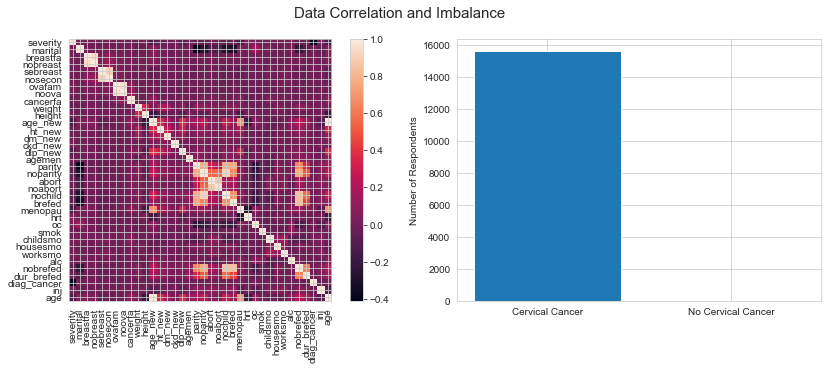

In [56]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12 , 5))

corr = data.corr()
im = ax1.imshow(corr)
ax1.set_xticks(range(len(corr.columns)))
ax1.set_xticklabels(corr.columns, rotation = 90)
ax1.set_yticks(range(len(corr.columns)))
ax1.set_yticklabels(corr.columns)
plt.colorbar(im, ax = ax1)

x = np.arange(2)
ax2.bar(x, height = [len(y[y == 1]), len(y[y == -1])])
ax2.set_xticks(x, ['Cervical Cancer', 'No Cervical Cancer'])
ax2.set_ylabel('Number of Respondents')

fig.suptitle('Data Correlation and Imbalance', size = 15)
plt.tight_layout()
plt.show()


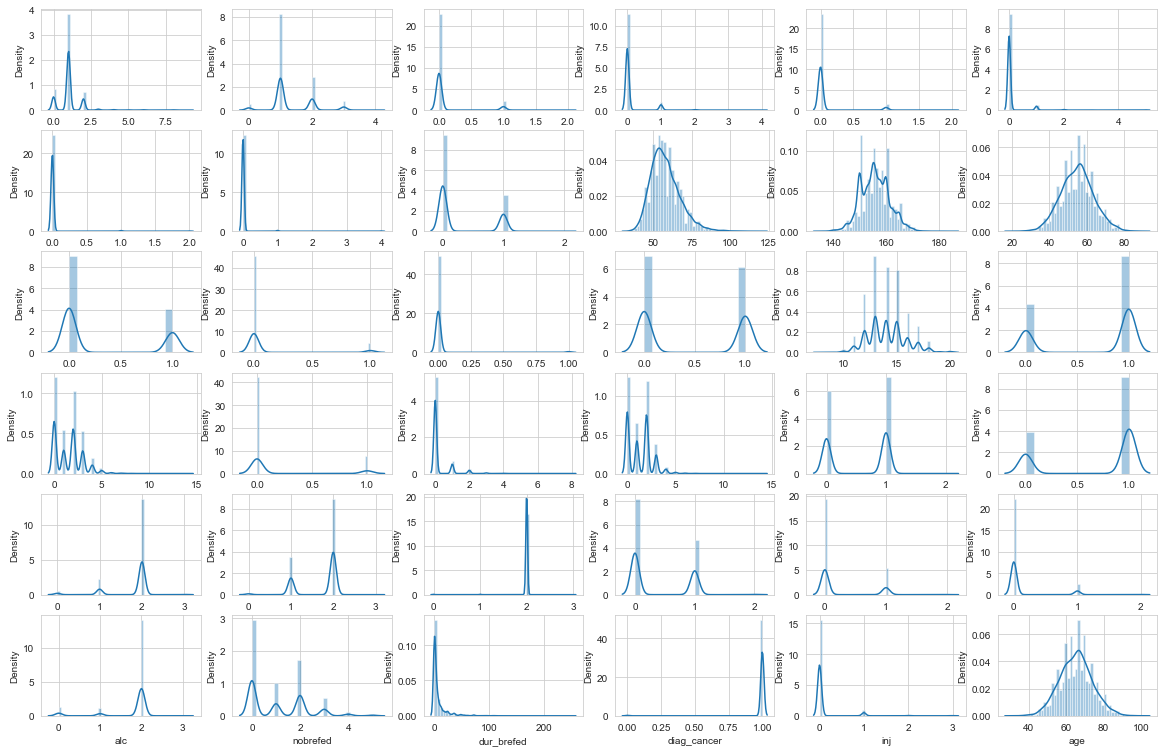

In [61]:
l = data.columns.values

plt.figure(figsize = (20, 13))
for i in range(0,len(l)):
    plt.subplot(6, 6, i + 1)
    sns.set_style('whitegrid')
    sns.distplot(data[l[i]], kde = True) 

## Ensemble Models: AdaBoost, Gradient Boosting, and XGBoost

In [93]:
def model_train(model, X_train, y_train, X_test, y_test):
    start = time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    class_names = ['Cancer', 'No Cancer']
    
    confusion = confusion_matrix(y_test, y_pred)
    
    print("Accuracy Score: ", np.round(accuracy_score(y_test, y_pred), 3))
    print('Confusion Matrix : \n', confusion)
    
    print(classification_report(y_test, y_pred, target_names = class_names))
    print(f"\t Fit and predict time: {np.round(time() - start, 3)} seconds")

### Adaptive Boosting

In [94]:
def train_adaboost(X_train, y_train, X_test, y_test, use_smote = False):
    if use_smote is True:
        smote = SMOTE(sampling_strategy = 'minority', k_neighbors = 10, random_state = 42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

    param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
                  'ccp_alpha'   : np.arange(0.001, 0.1, 0.01),
                  'max_depth'   : np.arange(1, 5),
                  'criterion'   : ['gini', 'entropy']}

    tree_class = DecisionTreeClassifier(max_depth = 5, random_state = 1024)
    grid_search = GridSearchCV(estimator = tree_class, 
                            param_grid = param_grid, 
                            cv = 5, 
                            verbose = True,
                            scoring = 'accuracy')

    grid_search = grid_search.fit(X_train, y_train)
    adaboost_dct = AdaBoostClassifier(grid_search.best_estimator_, 
                                    n_estimators  = 10, 
                                    random_state  = 42, 
                                    learning_rate = 0.001)
    model_train(adaboost_dct, X_train, y_train, X_test, y_test)

train_adaboost(X_train, y_train, X_test, y_test, use_smote = False)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Accuracy Score:  0.994
Confusion Matrix : 
 [[   0   27]
 [   0 4689]]
              precision    recall  f1-score   support

      Cancer       0.00      0.00      0.00        27
   No Cancer       0.99      1.00      1.00      4689

    accuracy                           0.99      4716
   macro avg       0.50      0.50      0.50      4716
weighted avg       0.99      0.99      0.99      4716

	 Fit and predict time: 0.15 seconds


In [95]:
train_adaboost(X_train, y_train, X_test, y_test, use_smote = True)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Accuracy Score:  0.984
Confusion Matrix : 
 [[  21    6]
 [  69 4620]]
              precision    recall  f1-score   support

      Cancer       0.23      0.78      0.36        27
   No Cancer       1.00      0.99      0.99      4689

    accuracy                           0.98      4716
   macro avg       0.62      0.88      0.68      4716
weighted avg       0.99      0.98      0.99      4716

	 Fit and predict time: 0.525 seconds


### Gradient Boosting

In [96]:
def train_gradientboost(X_train, y_train, X_test, y_test, use_smote = False):
    if use_smote is True:
        smote = SMOTE(sampling_strategy = 'minority', k_neighbors = 10, random_state = 42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        
    param_grid = {'learning_rate': [0.1, 0.01, 0.001, 0.0001],
                'subsample': [1.0, 0.5],
                'max_features': np.arange(0, 10), 
                'max_depth': np.arange(0, 5)}

    gradient_boosting = GradientBoostingClassifier(n_estimators = 10, 
                                    learning_rate = 0.1, 
                                    random_state = 0)

    grid_search = GridSearchCV(estimator = gradient_boosting, 
                            param_grid = param_grid, 
                            cv = 5, 
                            verbose = True,
                            scoring = 'accuracy')
    model_train(grid_search, X_train, y_train, X_test, y_test)

train_gradientboost(X_train, y_train, X_test, y_test, use_smote = False)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Accuracy Score:  0.993
Confusion Matrix : 
 [[  14   13]
 [  18 4671]]
              precision    recall  f1-score   support

      Cancer       0.44      0.52      0.47        27
   No Cancer       1.00      1.00      1.00      4689

    accuracy                           0.99      4716
   macro avg       0.72      0.76      0.74      4716
weighted avg       0.99      0.99      0.99      4716

	 Fit and predict time: 105.625 seconds


In [97]:
train_gradientboost(X_train, y_train, X_test, y_test, use_smote = True)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Accuracy Score:  0.988
Confusion Matrix : 
 [[  10   17]
 [  40 4649]]
              precision    recall  f1-score   support

      Cancer       0.20      0.37      0.26        27
   No Cancer       1.00      0.99      0.99      4689

    accuracy                           0.99      4716
   macro avg       0.60      0.68      0.63      4716
weighted avg       0.99      0.99      0.99      4716

	 Fit and predict time: 355.522 seconds


### Extreme Gradient Boosting

In [98]:
def train_xgboost(X_train, y_train, X_test, y_test, use_smote = False):
    if use_smote is True:
        smote = SMOTE(sampling_strategy = 'minority', k_neighbors = 10, random_state = 42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    xgboost = xgb.XGBClassifier(n_estimators = 10, 
                                objective  = 'binary:logistic',
                                reg_lambda = 0,
                                gamma  = 1,
                                max_depth = 6,
                                eta = 0.3,
                                scale_pos_weight = 10)
    xgboost.fit(X_train, y_train)
    model_train(xgboost, X_train, y_train, X_test, y_test)
train_xgboost(X_train, y_train, X_test, y_test, use_smote = False)

Accuracy Score:  0.996
Confusion Matrix : 
 [[  11   16]
 [   3 4686]]
              precision    recall  f1-score   support

      Cancer       0.79      0.41      0.54        27
   No Cancer       1.00      1.00      1.00      4689

    accuracy                           1.00      4716
   macro avg       0.89      0.70      0.77      4716
weighted avg       1.00      1.00      1.00      4716

	 Fit and predict time: 0.159 seconds


In [99]:
train_xgboost(X_train, y_train, X_test, y_test, use_smote = True)

Accuracy Score:  0.996
Confusion Matrix : 
 [[  12   15]
 [   4 4685]]
              precision    recall  f1-score   support

      Cancer       0.75      0.44      0.56        27
   No Cancer       1.00      1.00      1.00      4689

    accuracy                           1.00      4716
   macro avg       0.87      0.72      0.78      4716
weighted avg       1.00      1.00      1.00      4716

	 Fit and predict time: 0.383 seconds
